In [11]:
# For portfolio A, if there exists an alternative portfolio B that is 
# at least as good or better in every dimension, and portfolio B is better in at least one dimensino
# then this portfolio is redundant, and we can systematically discard it from consideration.

# Let's see what that looks like -- how well does it reduce the field?
# Can we do this analysis entirely in sqlite?

import pandas as pd
import sqlite3
import seaborn as sns
from timeit import default_timer as timer

# Read sqlite query results into a pandas DataFrame
def query(query):
    con = sqlite3.connect("output/portfolios.sqlite")
    df = pd.read_sql_query(query, con)
    con.close()
    return df

In [3]:
# start with just portfolios of up to 3 assets
query("SELECT COUNT(*) FROM portfolios WHERE num_assets <= 3")

,COUNT(*)
0,24857


In [4]:
# Create a trimmed down portfolios table with reduced num_assets
con = sqlite3.connect("output/portfolios.sqlite")
cur = con.cursor()
cur.execute("""
    CREATE TABLE portfolios_max_3_assets AS
    SELECT * FROM portfolios
    WHERE num_assets <= 3
""")
con.commit()
con.close()

In [5]:
query("SELECT COUNT(*) FROM portfolios_max_3_assets")

,COUNT(*)
0,24857


In [6]:
query("SELECT * FROM portfolios_max_3_assets LIMIT 1")

,assets,num_assets,num_years,avg_return,baseline_lt_return,baseline_st_return,pwr30,swr30,std_dev,ulcer_score,deepest_drawdown,longest_drawdown,startdate_sensitivity,pwr10,pwr10_stdev,pwr10_slope,pwr30_stdev,pwr30_slope
0,|Commodity Futures|,1,52,0.044149,-0.053216,-0.106503,-0.051271,0.024611,0.225833,170.085366,-0.810595,14.0,0.286495,-0.150707,0.061643,-0.344271,0.032025,-0.424845


In [7]:
# Create a copy of that table with "score" columns added
# Create a trimmed down portfolios table, eliminating those assets
con = sqlite3.connect("output/portfolios.sqlite")
cur = con.cursor()
cur.execute("""
    CREATE TABLE portfolios_max_3_assets_scored AS
    SELECT *,
      num_years              AS score1,
      avg_return             AS score2,
      baseline_lt_return     AS score3,
      baseline_st_return     AS score4,
      pwr30                  AS score5,
      swr30                  AS score6,
      -std_dev               AS score7,
      -ulcer_score           AS score8,
      deepest_drawdown       AS score9,
      -longest_drawdown      AS score10,
      -startdate_sensitivity AS score11,
      pwr10                  AS score12,
      -pwr10_stdev           AS score13,
      -pwr30_stdev           AS score13,
      MIN(pwr10_slope, -0.025)+0.025 AS score14,
      MIN(pwr30_slope, -0.025)+0.025 AS score15
    FROM portfolios_max_3_assets
""")
con.commit()
con.close()

In [8]:
query("SELECT * FROM portfolios_max_3_assets_scored LIMIT 1")

,assets,num_assets,num_years,avg_return,baseline_lt_return,baseline_st_return,pwr30,swr30,std_dev,ulcer_score,...,score7,score8,score9,score10,score11,score12,score13,score13:1,score14,score15
0,|Commodity Futures|,1,52,0.044149,-0.053216,-0.106503,-0.051271,0.024611,0.225833,170.085366,...,-0.225833,-170.085366,-0.810595,-14.0,-0.286495,-0.150707,-0.061643,-0.032025,-0.319271,-0.399845


In [9]:
# Index that table by all of the scores
con = sqlite3.connect("output/portfolios.sqlite")
cur = con.cursor()
cur.execute("""
    CREATE INDEX portfolios_max_3_assets_scored_index_all_scores
    ON portfolios_max_3_assets_scored (
      score1,
      score2,
      score3,
      score4,
      score5,
      score6,
      score7,
      score8,
      score9,
      score10,
      score11,
      score12,
      score13,
      score14,
      score15
    )
""")
con.commit()
con.close()

In [10]:
# Identify each row, whether it's redundant or not
query("""
WITH portfolios_with_isredundant AS (
    SELECT *,
      EXISTS(
          SELECT *
          FROM portfolios_max_3_assets_scored AS b
          WHERE b.score1 >= a.score1
            AND b.score2 >= a.score2
            AND b.score3 >= a.score3
            AND b.score4 >= a.score4
            AND b.score5 >= a.score5
            AND b.score6 >= a.score6
            AND b.score7 >= a.score7
            AND b.score8 >= a.score8
            AND b.score9 >= a.score9
            AND b.score10 >= a.score10
            AND b.score11 >= a.score11
            AND b.score12 >= a.score12
            AND b.score13 >= a.score13
            AND b.score14 >= a.score14
            AND b.score15 >= a.score15
            AND b.assets != a.assets
      ) AS is_redundant
    FROM portfolios_max_3_assets_scored AS a
)
SELECT is_redundant, COUNT(*)
FROM portfolios_with_isredundant
GROUP BY is_redundant
""")

,is_redundant,COUNT(*)
0,0,5813
1,1,19044


In [12]:
# Create a trimmed down portfolios3 table with
start = timer()
con = sqlite3.connect("output/portfolios.sqlite")
cur = con.cursor()
cur.execute("""
    CREATE TABLE portfolios_max_3_assets_withredundant AS
    SELECT *,
      EXISTS(
          SELECT *
          FROM portfolios_max_3_assets_scored AS b
          WHERE b.score1 >= a.score1
            AND b.score2 >= a.score2
            AND b.score3 >= a.score3
            AND b.score4 >= a.score4
            AND b.score5 >= a.score5
            AND b.score6 >= a.score6
            AND b.score7 >= a.score7
            AND b.score8 >= a.score8
            AND b.score9 >= a.score9
            AND b.score10 >= a.score10
            AND b.score11 >= a.score11
            AND b.score12 >= a.score12
            AND b.score13 >= a.score13
            AND b.score14 >= a.score14
            AND b.score15 >= a.score15
            AND b.assets != a.assets
      ) AS is_redundant
    FROM portfolios_max_3_assets_scored AS a
""")
con.commit()
con.close()
print("elapsed:", timer()-start)

elapsed: 18.794136065999965


In [13]:
query("SELECT is_redundant, COUNT(*) FROM portfolios_max_3_assets_withredundant GROUP BY is_redundant")

,is_redundant,COUNT(*)
0,0,5813
1,1,19044


24857


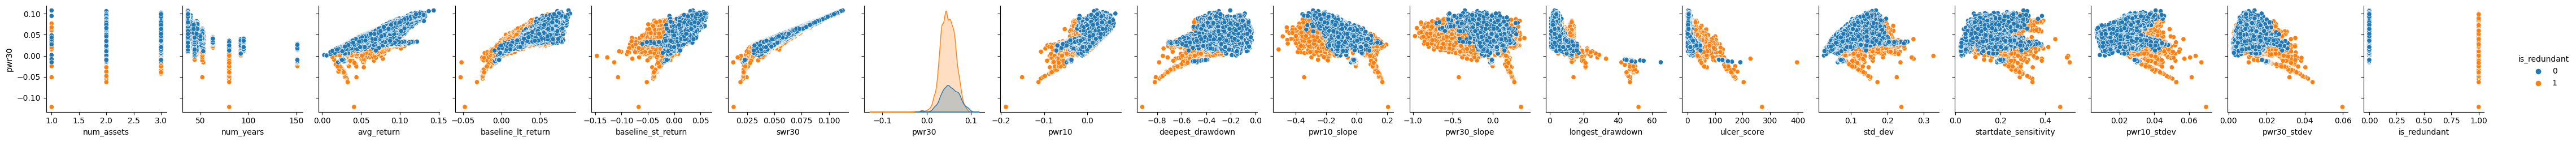

In [15]:
metrics = """
    num_assets,
    num_years,
    avg_return,
    baseline_lt_return,
    baseline_st_return,
    swr30,
    pwr30,
    pwr10,
    deepest_drawdown,
    pwr10_slope,
    pwr30_slope,
    -- metrics where lower is better
    longest_drawdown,
    ulcer_score,
    std_dev,
    startdate_sensitivity,
    pwr10_stdev,
    pwr30_stdev
"""
df = query("""
  SELECT assets, """+metrics+""", is_redundant
  FROM portfolios_max_3_assets_withredundant
  ORDER BY is_redundant DESC
""")
print(df['assets'].size)
sns.pairplot(df, y_vars=['pwr30'], x_vars=df.columns.values[1:], hue='is_redundant')

24857


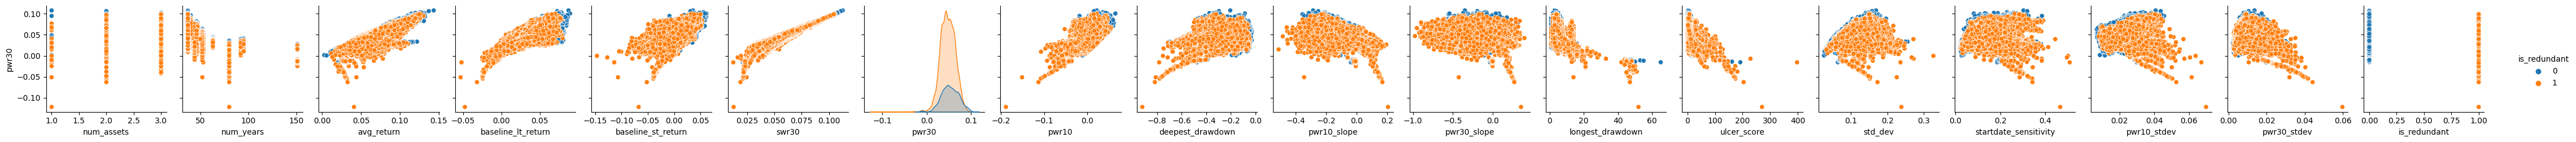

In [16]:
df = query("""
  SELECT assets, """+metrics+""", is_redundant
  FROM portfolios_max_3_assets_withredundant
  ORDER BY is_redundant ASC
""")
print(df['assets'].size)
sns.pairplot(df, y_vars=['pwr30'], x_vars=df.columns.values[1:], hue='is_redundant')

5813


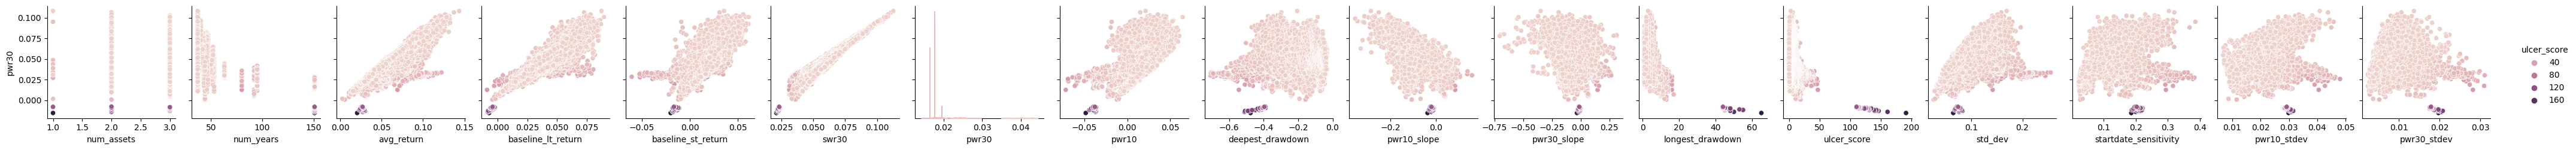

In [17]:
df = query("""
  SELECT assets, """+metrics+"""
  FROM portfolios_max_3_assets_withredundant
  WHERE is_redundant = 0
  ORDER BY ulcer_score DESC
""")
print(df['assets'].size)
sns.pairplot(df, y_vars=['pwr30'], x_vars=df.columns.values[1:], hue='ulcer_score')